### Osceola CFLRP 


#### Required libraries
and data directories

In [138]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
import fiona
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection


dataDir = 'Z:/Dan K/Osceola/'
rasterDir = dataDir + 'Ecoregion Generation/Rasters/'
shapeDir = dataDir + 'Ecoregion Generation/Shapefiles/'

#### Define some custom functions 
These will soon be wrapped up into a module to clean up the notebooks


In [ ]:
def importRaster(rasterPath, **kwargs):
    # Open and read in the raster as an array
    raster_ds = gdal.Open(rasterPath)
    rastermap = raster_ds.ReadAsArray()
    
    # Set the default data type to 'float'
    if 'dtype' not in kwargs:
        dtype = 'float'
    rastermap = rastermap.astype(dtype)
    
    # If specified, set the no data value to NaN
    if 'noData' in kwargs:
        rastermap[rastermap == noData] = np.nan
    return rastermap

def plotRaster(image, ax=None, *args, **kwargs):

    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
                   
    # Normalize color scheme
    if 'norm' not in kwargs:
        vmin = kwargs.pop('vmin', None)
        vmax = kwargs.pop('vmax', None)
        if vmin is None:
            vmin = np.min(rastermap) # or what ever
        if vmax is None:
            vmax = np.max(rastermap)
        norm = matplotlib.colors.Normalize(vmin, vmax)
        kwargs['norm'] = norm

    #ax.figure.canvas.draw() # if you want to force a re-draw
    ax.imshow(image, *args, **kwargs)
    # Setup axes
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
def getShpGeom(shapefile):
    shp = fiona.open(shapefile)
    bds = shp.bounds
    shp.close()
    
    ll = (bds[0] + padLON, bds[1] + padLAT)
    ur = (bds[2] - padLON, bds[3] - padLAT)
    midlat = (bds[1] + bds[3]) / 2
    midlon = (bds[0] + bds[2]) / 2
    coords = list(chain(ll, ur))
    return coords, midlat, midlon


#### Lets define our analysis extent
The Osceola national forest is in north Florida, what area are we actually going to try and model?

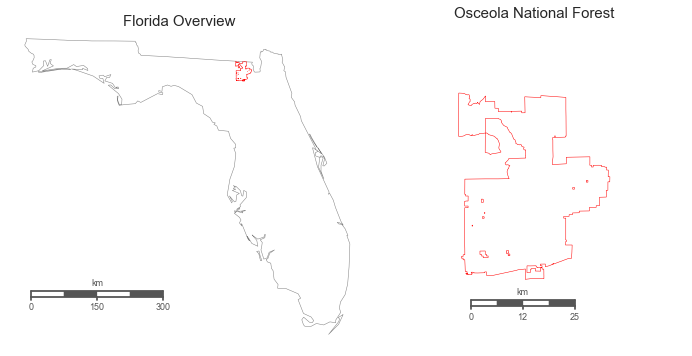

In [280]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
sns.set_style('white')
sns.despine(left = True, bottom = True)

coords, midlat, midlon = getShpGeom(shapeDir + 'Florida_State.shp')

m = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax1);

m.readshapefile(shapeDir + 'Florida_State', 'Florida',
    color='gray', zorder=5);
m.readshapefile(shapeDir + 'OsceolaShape', 'Osceola',
    color='red', zorder=5);


m.drawmapscale(
    coords[0]+2, coords[1]+1,
    coords[0], coords[1],
    300.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

coords, midlat, midlon = getShpGeom(shapeDir + 'OsceolaShape.shp')

m1 = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax2);

m1.readshapefile(shapeDir + 'OsceolaShape', 'Osceola',
    color='red', zorder=5);

m1.drawmapscale(
    coords[0] + 0.35, coords[1] + 0.1,
    coords[0], coords[1],
    25.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

ax1.set_title('Florida Overview', fontsize = 15)
ax2.set_title('Osceola National Forest', fontsize = 15)
plt.tight_layout()
plt.savefig('AreaOverview.tif')

#### Ecoregion generation
First step toward building the Osceola into LANDIS-II is to generate ecoregions -- climatically and edaphically similar areas, wherein soil and climate will provide the same drivers for vegetation growth. The Osceola isn't a huge area (~90k ha) and also is not exceptionally mountainous. This should make creating ecoregions a simple affair. 

The strategy will be to leverage GSSURGO data to describe the major soil types across the landscape, and look for differences in for example water holding capacity. Then we will overlay those differences with crude elevation bands, using elevation as a surrogate for climate -- so long as precipitation and temperature appear to vary across an elevation gradient within the study area.

####GSSURGO data
This always gives me a headache. So here are the steps I used to make sense of the GSSURGO data once its downloaded. I downloaded the data from https://gdg.sc.egov.usda.gov/ on 8-28-2016
1. Load the MapunitRaster into a GIS of your  choice
2. Import two data tables, 'chorizon' and 'component'. I don't understand the naming convention here, chorizon isn't a word, so presumably this stands for c horizon, as the table has a lot of soil horizon data -- clay, sand, silt at various depths etc. However the same logic cannot be applied to 'component', as c omponent doesn't make any sense...
3. Create a spatial join between the MapunitRaster and 'component' using 'MUKEY' from the MapunitRaster (presumably standing for Mapunit Key) and 'Mapunit Key' from 'component'. Why both columns aren't called the same thing, when in fact they represent the same data ...
4. Create a spatial join between MapunitRaster and 'chorizon' using the newly acquired 'Component Key' from MapunitRaster.component. 'chorizon' has the same name for its 'Component Key' column, just to futher add to the confusion via a moment of clarity.
5. Now you have access to the spatial data from 'chorizon' and 'component' on a per MapunitRaster basis.
6. If you want to access the parent group material, useful for splitting up the analysis area into edaphically dissimilar chunks, you need to access the 'copm' table. To make use of it, you need to join it to the MapunitRaster via the 'Component Parent Material Group Key' attribute, which doesn't exist in any of the tables we've joined so far. So, we need an intermediate join that speaks both languages -- namely 'copmgrp'. By joining 'copmgrp' to MapunitRaster via 'Component Key', we can access the parent material columns spatially via our MapunitRaster layer.

The next step isn't entirely intuitive either -- clipping the resulting geodatabase to a smaller vector (e.g., clipping the GSSURGO data for all of FL to just the Osceola extent) requires clipping the 'MUPOLYGON' feature inside the GSSURGO geodatabase. In that manner you end up with a clipped .gdb that retains all associations with the MUKEY and consequently Mapunit Key fields, which you can still relate to soil properties following the steps above.

#### Take a look at edaphic patterns
that might explain some of the variability in soils across the Osceola. Here, sand, silt, and clay content varies spatially, with some start differences across the center of the region. So stark that its probably not real -- this is an artifact of the spatial averaging that goes on within the gSSURGO data. But, its really not that big of a deal, given the tiny range of variability were dealing with. 

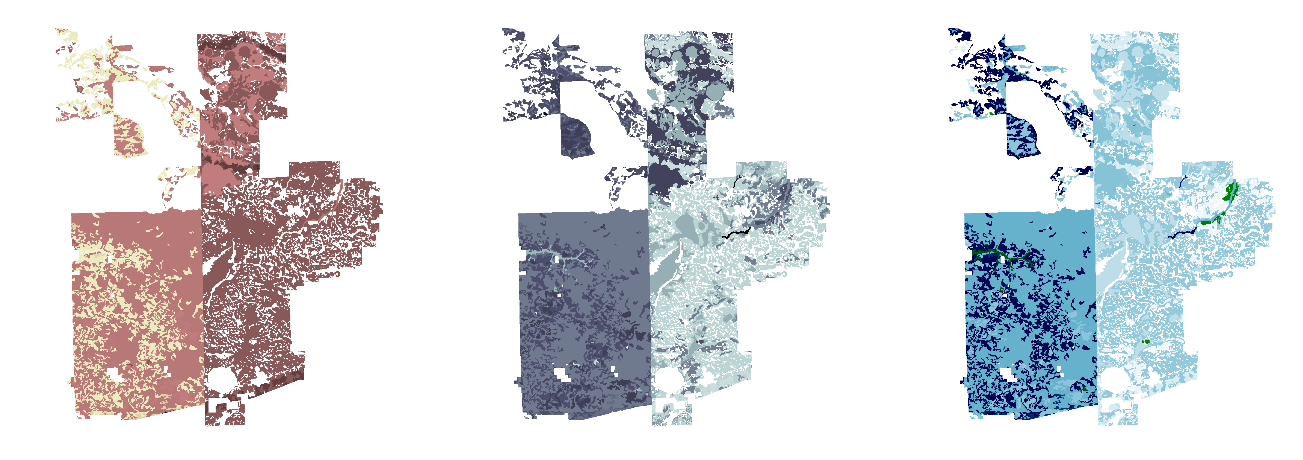

In [130]:
sand = importRaster(dataDir + 'Ecoregion Generation/osceola_sand.tif')
silt = importRaster(dataDir + 'Ecoregion Generation/osceola_silt.tif')
clay = importRaster(dataDir + 'Ecoregion Generation/osceola_clay.tif')

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (24,8))
plotRaster(sand, ax1, cmap = 'pink_r', vmin = 70, vmax = 100)
plotRaster(silt, ax2, cmap = 'bone_r', vmin = 0, vmax = 10)
plotRaster(clay, ax3, cmap = 'ocean_r', vmin = 0, vmax = 25)
plt.subplots_adjust(wspace = 0, hspace = 0.05)
for ax in f.axes:
    ax.set_xticklabels('')
    ax.set_yticklabels('')
